# Homework 1. Likelihood-based models

- **Task 1 (5 points): Warmup**
- Task 2 (10 points): PixelCNN
- Task 3 (10 points): Conditional PixelCNN
- Task 4 (10 points): RealNVP
- \* Bonus (10+++ points)

# Warmup task

In this task we will play with simplest likelihood-based models with both 1D and 2D data. The task consists of 2 parts:
- Likelihood model in 1D - fitting histogram using SGD
- Deep Autoregressive model in 2D

# Part 1. Fitting histogram

In this part we will build our first likelihood-based model for 1D data and will try to fit it using gradient methods.

In [1]:
%matplotlib inline

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
import torch
from torch import nn
from torch import optim
from torch.nn import functional as F
import torch.utils.data
import math
from sklearn.model_selection import train_test_split
import random

Choose your device: don't forget to switch to GPU runtime when working in colab with cuda.

In [3]:
device = 'cuda'

First, we define the procedure of data generation. It will generate a dataset of samples $x \in \{0 \dots 99\}$

In [4]:
def sample_data():
    count = 10000
    rand = np.random.RandomState(0)
    a = 0.3 + 0.1 * rand.randn(count)
    b = 0.8 + 0.05 * rand.randn(count)
    mask = rand.rand(count) < 0.5
    samples = np.clip(a * mask + b * (1 - mask), 0.0, 1.0)
    
    return np.digitize(samples, np.linspace(0.0, 1.0, 100))

We generate data and perform train/val/test split.

In [5]:
data = sample_data()
train_data, test_data = train_test_split(data, test_size = 0.3)
train_data, val_data = train_test_split(train_data, test_size = 0.3)

Let's plot and visualize the histogram of training data!

In [6]:
def plot_histogram(data):
    counts = Counter(data)
    keys = list(counts.keys())
    values = list(counts.values())
    plt.bar(keys, values)
    plt.show()

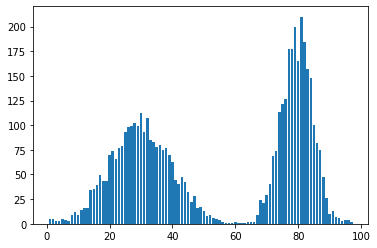

In [7]:
plot_histogram(train_data)

On lecture we have discussed how to build histogram model. But this model is not the best choice for high-dimensional data. So, we suggest you to implement the following parametrized model:

$$ p_\theta(x)_i = \frac{e^{\theta_i}}{\sum_j{e^{\theta_j}}} $$

Where $\theta=(\theta_0 \dots \theta_{99})$

We propose you to implement this model in the following class

In [8]:
class SimpleProbabilityModel(nn.Module):
    # Store all parameters of your model as class fields in constructor
    def __init__(self,  num_elements=100):
        super(SimpleProbabilityModel, self).__init__()
        self.thetas = nn.Parameter(torch.randn(num_elements).type(torch.FloatTensor), requires_grad=True)
        self.probs = torch.zeros(num_elements)
        self.softmax = nn.Softmax(dim=0)
        self.num_elements = num_elements
        
    # Forward should return vector of log probabilities for each element
    def forward(self):
        self.probs = self.softmax(self.thetas)
        return torch.log(self.probs)
    
    # Should sample element using probabilities, obtained from parameters. Return single number 0..99
    def sample(self):
        return np.random.choice(list(range(0, self.num_elements)), p=self.probs.detach().cpu().numpy())

We will train this model using negative log-likelihood optimization: $ L_i = -\log p_{y_i} $. Implement this loss calculation for your model given a batch of data samples.

In [9]:
# data: n.array of numbers from your training distribution
# model: instance of your SimpleProbabilityModel.
# should return: negative log-likelihood of your data given the model to perform backpropagation
def calc_loss(data, model):
    probs = model.forward()
    data = torch.tensor(data).to(device)
    return torch.mean(-torch.index_select(probs, 0, data))

Finally, we can create instance of our model and perform training. Note that if you calculated previous loss as classic natural logarithm, here we scale it to binary logarithm for logging likelihood in bits (which is better for interpretation and comparisons).

In [10]:
model = SimpleProbabilityModel().to(device)

In [11]:
def train_simple_model(model, train_data, val_data, num_epochs=1000, batch_size=4000, lr=0.3):
    optimizer = optim.SGD(model.parameters(), lr=lr)
    train_losses = []
    val_losses = []
    for i in range(num_epochs):
        for j in range(len(train_data) // batch_size):
            optimizer.zero_grad()
            batch = train_data[batch_size * j:batch_size * (j + 1)]
            l = calc_loss(batch, model)
            train_losses.append(l.item() / math.log(2))
            l.backward()
            optimizer.step()
        l = calc_loss(val_data, model)
        val_losses.append(l.item() / math.log(2))
    
    print("Train NLL(bits)")
    plt.plot(train_losses, color='green')
    plt.show()

    print("Val NLL(bits)")
    plt.plot(val_losses, color='red')
    plt.show()
    
    print("Final validation NLL(bits): {}".format(val_losses[-1]))

Train NLL(bits)


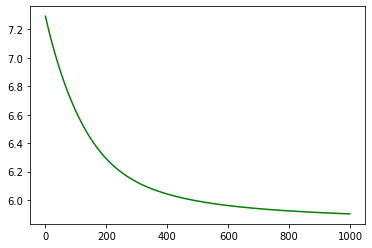

Val NLL(bits)


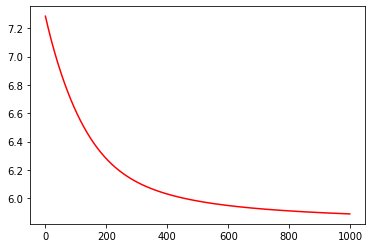

Final validation NLL(bits): 5.888494032904205


In [12]:
train_simple_model(model, train_data, val_data)

You can also tune your training parameters (number of epochs, batch size, learning rate, optimizer), to improve validation NLL. You should obtain something below 6.

Finally, let's sample values from our model and visualize histograms of our test data and our sample data.

In [13]:
sampled_data = [model.sample() for _ in range(len(test_data))]

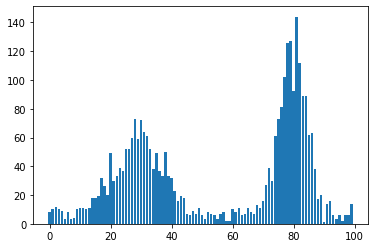

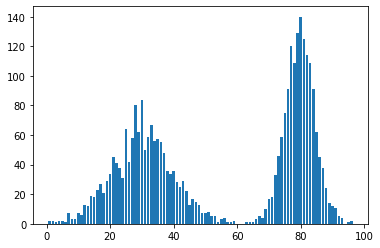

In [14]:
plot_histogram(sampled_data)
plot_histogram(test_data)

Training here might not yield perfect results, but pictures should look at least similar.

# Part 2. 2D discrete data. Autoregressive model

In this part we will build our own autoregressive model to work with two-dimensional discrete data. 

We will load 2D distribution as is from file. It's a 200x200 numpy array with probabilities.

In [15]:
# For colab users: download file
! wget https://github.com/egiby/Generative-Models-MIPT/raw/main/module1-likelihood/distribution.npy

--2022-03-11 20:50:40--  https://github.com/egiby/Generative-Models-MIPT/raw/main/module1-likelihood/distribution.npy
Resolving github.com (github.com)... 140.82.121.3
Connecting to github.com (github.com)|140.82.121.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/egiby/Generative-Models-MIPT/main/module1-likelihood/distribution.npy [following]
--2022-03-11 20:50:40--  https://raw.githubusercontent.com/egiby/Generative-Models-MIPT/main/module1-likelihood/distribution.npy
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 160128 (156K) [application/octet-stream]
Saving to: ‘distribution.npy.5’

distribution.npy.5  100%[===================>] 156.38K  --.-KB/s    in 0.008s  

2022-03-11 20:50:40 (1

In [16]:
original_distribution = np.load("distribution.npy")

Let's define class to sample pair of numbers $(x,y) \in \{0 \dots 199\}^2$ from this distribution.

In [17]:
class SampleDist:
    def __init__(self, distribution):
        self.probabilities = distribution.flatten()
        self.rows, self.cols = distribution.shape
        self.values = np.array([[i // self.cols, i % self.cols] for i in range(self.rows * self.cols)])

    def sample(self):
        idx = np.random.choice(self.rows * self.cols, p = self.probabilities)
        
        return self.values[idx]

So, we define distribution, sample data and create train/val/test splits.

In [18]:
dist2D = SampleDist(original_distribution)

In [19]:
SIZE = 100000
sampled_data = np.array([dist2D.sample() for _ in range(SIZE)])

In [20]:
train_data, test_data = train_test_split(sampled_data, test_size = 0.2)
train_data, val_data = train_test_split(train_data, test_size = 0.2)

We will build our autoregressive model in $(x, y)$ as follows:

- Train marginal model $p(x)$ as in part 1
- Create and train conditional model $p(y|x)$ as multi-layer neural network

Here, create class for your conditional model $p(y|x)$. It should take $x$ as batch of integer inputs and return batch of probability distributions over $y$.

In [21]:
class ConditionalModel(nn.Module):
    # Store all your trainable layers as model fiels in constuctor
    def __init__(self):
        super(ConditionalModel, self).__init__()
        self.prob_layer = nn.Sequential(
            nn.Linear(1, 64),
            nn.ReLU(),
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128, 200),
            nn.LogSoftmax(dim=1)
        )

    # Forward pass takes LongTensor x of shape (N,) and should return predicted logprobs of shape (N, 200)
    def forward(self, x):
        x = x.unsqueeze(1).float().to(device)
        return self.prob_layer(x)

Finally, create a model and train it.

In [22]:
cond_model = ConditionalModel().to(device)

In [23]:
def train_cond_model(cond_model, train_data, num_epochs=100, lr=0.001, batch_size=10000):
    dataset = torch.utils.data.TensorDataset(torch.LongTensor(train_data.T[0]).to(device), 
                                             torch.LongTensor(train_data.T[1]).to(device))
    dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)
    loss = nn.NLLLoss()
    optimizer = optim.Adam(cond_model.parameters(), lr=lr)
    
    train_losses = []
    
    for i in range(num_epochs):
        for X_train, Y_train in dataloader:
            optimizer.zero_grad()
            predictions = cond_model(X_train)
            l = loss(predictions, Y_train)
            l.backward()
            optimizer.step()
            
            train_losses.append(l.item() / math.log(2))
    
    print("Train NLL(bits)")
    plt.plot(train_losses, color='green')
    plt.show()

Train NLL(bits)


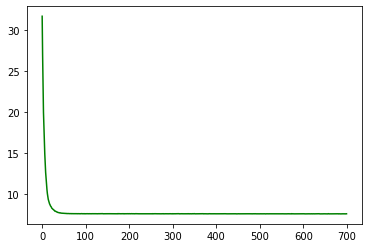

In [24]:
train_cond_model(cond_model, train_data)

To build compound model, we will also need our simple model from part 1, trained on marginal data from our distribution (only x values).

Train NLL(bits)


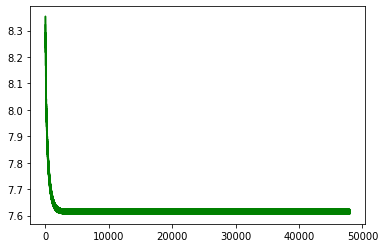

Val NLL(bits)


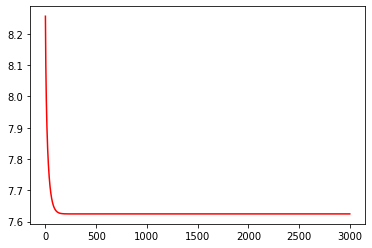

Final validation NLL(bits): 7.624327310813395


In [25]:
x_model = SimpleProbabilityModel(num_elements=200).to(device)
train_simple_model(x_model, train_data.T[0], val_data.T[0], num_epochs=3000)

Finally, we are ready to build compound model for our total $(x, y)$ distribution modeling. Having two trained models implement sampling procedure and probability calculation.

In [26]:
class CompoundModel:
    def __init__(self, x_model, cond_model):
        self.x_model = x_model
        self.cond_model = cond_model
        
        self.x_model.eval()
        self.cond_model.eval()
    
    # Given two numbers x, y from 0 .. 199, return NLL value -log p(x,y)
    # Normalize in the way it will return NLL in bits / dimention (binary log divided by two in our case)
    def get_logprob(self, x, y):
        x_prob = self.x_model()[x]
        y_x_prob = self.cond_model(torch.tensor([x]))[0][y]
        return - (x_prob + y_x_prob) / 2
    
    # Implement sampling procedure. One call should return sample (x, y) as numpy array from two elements
    def sample(self):
        x = x_model.sample()
        probs = torch.exp(cond_model.forward(torch.tensor([x])))
        y = np.random.choice(list(range(0, 200)), p=probs.detach().cpu().numpy().flatten())
        return (x, y)


In [27]:
compound_model = CompoundModel(x_model, cond_model)

Calculate total average NLL in bits / dimension on your validation data. Tune training parameters and conditional model architecture to boost your performance.

In [28]:
total_logprob = 0
for elem in val_data:
    logprob = compound_model.get_logprob(elem[0], elem[1])
    total_logprob += logprob
print("Total NLL on validation data per dimension: {}".format(total_logprob / val_data.shape[0]))

Total NLL on validation data per dimension: 5.284794330596924


Check if sampling from your model works.

In [29]:
compound_model.sample()

(12, 5)

Finally, get enough samples from your final model and display 2D histogram of the results. Compare them with the results you can get from your test data.

In [30]:
sampled_2d_data = np.array([compound_model.sample() for _ in range(test_data.shape[0])])

In [31]:
def plot_2dhistogram(data):
    plt.hist2d(data.T[0], data.T[1], bins=200, cmap='gray')
    plt.show()

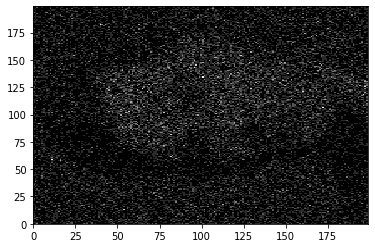

In [32]:
# plot_2dhistogram(sampled_2d_data)
plot_2dhistogram(test_data)

Doesn't this picture resemble anything? (look at the rotated version of the histogram). Check out how your original distribution looks like!

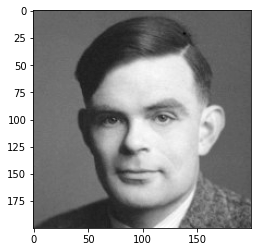

In [33]:
plt.imshow(original_distribution, cmap="gray")
plt.show()